# Projeto – Scraper Mercado Livre  
Coleta anúncios, extrai detalhes, remove colunas pouco povoadas e grava CSVs organizados por execução.


## Instalação das bibliotecas

Execute a célula de código abaixo **uma única vez** para instalar as
dependências necessárias (ou pule se já estiverem no ambiente):

* `requests`, `beautifulsoup4`, `lxml` – scraping  
* `pandas` – manipulação de dados  
* `tqdm` – barra de progresso


In [99]:
!pip install -q requests beautifulsoup4 lxml pandas tqdm matplotlib


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [79]:
# Imports e configuração global
from pathlib import Path
from datetime import datetime
import time, random, math, re, json, csv, os

import requests, pandas as pd
from bs4 import BeautifulSoup
from tqdm.auto import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed


## Parâmetros editáveis
Altere palavras-chave, nº de páginas, atrasos e nº de threads.


In [80]:
KEYWORDS        = ["iphone-13", "iphone-14", "rtx-3060", "mac-mini-m4"]
PAGES_PER_KW    = 3               # páginas por keyword
REQUEST_DELAY   = (0.1, 1)          # intervalo (seg) entre downloads
MAX_WORKERS     = 12              # threads em paralelo
KEEP_THRESHOLD  = 0.70            # ≥70 % valores não-nulos
HEADERS = {
    "User-Agent": (
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
        "AppleWebKit/537.36 (KHTML, like Gecko) "
        "Chrome/124.0 Safari/537.36"
    )
}
ITEMS_PER_PAGE  = 48


## Estrutura de diretórios  
Cada run cria `runs/<YYYYMMDD-HHMMSS>/raw/` e `clean/`.


In [81]:
RUN_TS   = datetime.now().strftime("%Y%m%d-%H%M%S")
RUN_DIR  = Path("runs") / RUN_TS
RAW_DIR  = RUN_DIR / "raw"
CLN_DIR  = RUN_DIR / "clean"
for d in (RAW_DIR, CLN_DIR):
    d.mkdir(parents=True, exist_ok=True)
print("Run dir:", RUN_DIR.resolve())


Run dir: C:\Users\cesar\OneDrive\Desktop\Insper\Eletivas\analise_de_texto\Projeto_MercadoLivre\runs\20250518-181923


## Funções auxiliares – busca


In [82]:
def build_url(keyword: str, page: int) -> str:
    base = f"https://lista.mercadolivre.com.br/{keyword}"
    if page == 1:
        return base
    offset = (page - 1) * ITEMS_PER_PAGE + 1
    return f"{base}_Desde_{offset}"

def fetch_html(url: str) -> str:
    resp = requests.get(url, headers=HEADERS, timeout=20)
    resp.raise_for_status()
    return resp.text

def parse_cards(html: str, kw: str) -> list[dict]:
    soup  = BeautifulSoup(html, "lxml")
    items = soup.select("li.ui-search-layout__item")
    rows  = []
    for it in items:
        a = (it.select_one('a[class*="poly-component__title"]')
             or it.select_one("a.ui-search-item__group__element"))
        if not a: continue
        title = a.get_text(" ", strip=True)
        link  = a["href"].split("#")[0]
        price_tag = it.select_one("span.andes-money-amount__fraction")
        price = int(re.sub(r"[^\d]", "", price_tag.text)) if price_tag else None
        ship = (it.select_one("div.poly-component__shipping")
                or it.select_one("span.ui-search-item__shipping-info"))
        shipping = ship.get_text(" ", strip=True) if ship else None
        seller_tag = it.select_one("span.poly-component__seller")
        seller = seller_tag.get_text(" ", strip=True) if seller_tag else None
        rows.append(dict(keyword=kw, title=title, price=price,
                         url=link, shipping=shipping, seller=seller,
                         scraped_at=datetime.now()))
    return rows


## Coleta de cards – paralela por página


In [83]:
from concurrent.futures import ThreadPoolExecutor, as_completed

def scrape_keyword(keyword: str, pages: int) -> pd.DataFrame:
    """Busca TODAS as páginas de resultados em paralelo."""
    urls = [build_url(keyword, p) for p in range(1, pages + 1)]

    rows = []
    with ThreadPoolExecutor(max_workers=min(len(urls), MAX_WORKERS)) as ex:
        fut_html = {ex.submit(fetch_html, u): u for u in urls}

        for fut in tqdm(as_completed(fut_html),
                        total=len(fut_html), desc=f"{keyword} pages"):
            html = fut.result()
            rows += parse_cards(html, keyword)

    return pd.DataFrame(rows)

## Funções auxiliares – detalhes do anúncio


In [84]:
def parse_product(html: str) -> dict:
    soup = BeautifulSoup(html, "lxml")
    out  = {}

    t = soup.select_one("h1.ui-pdp-title")
    out["title_full"] = t.get_text(" ", strip=True) if t else None
    p = soup.select_one("span.ui-pdp-price__second-line")
    if not p:
        p = soup.select_one("span.andes-money-amount__fraction")
    if p: out["price_item"] = int(re.sub(r"[^\d]", "", p.text))
    cond = soup.select_one("span.ui-pdp-subtitle")
    out["condition"]   = cond.get_text(" ", strip=True) if cond else None
    sold = soup.select_one("span.ui-pdp-buybox__quantity__available")
    out["sold_qty"]    = sold.get_text(" ", strip=True) if sold else None
    seller = soup.select_one("span.ui-pdp-seller__link-trigger")
    out["seller"]      = seller.get_text(" ", strip=True) if seller else None
    st = soup.select_one("p.ui-pdp-seller__status-info")
    out["seller_status"] = st.get_text(" ", strip=True) if st else None
    ship = soup.select_one("p.ui-pdp-color--GREEN, p.ui-pdp-color--BLACK")
    out["shipping"]    = ship.get_text(" ", strip=True) if ship else None

    for row in soup.select("div.ui-vpp-striped-specs__table tr"):
        th = row.select_one("th")
        td = row.select_one("td span")
        if th and td:
            key = re.sub(r"\W+", "_", th.get_text(" ", strip=True).lower()).strip("_")
            out[key] = td.get_text(" ", strip=True)
    return out


## Visita de todos os anúncios – paralela por link


In [85]:
def enrich_with_details(df: pd.DataFrame) -> pd.DataFrame:
    details = []
    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as ex:
        fut_det = {
            ex.submit(fetch_html, url): url
            for url in df["url"].unique()
        }
        for fut in tqdm(as_completed(fut_det), total=len(fut_det), desc="Detalhes"):
            url = fut_det[fut]
            try:
                html = fut.result()
                det  = parse_product(html)
                det["url"] = url
                details.append(det)
                time.sleep(random.uniform(*REQUEST_DELAY))
            except Exception as e:
                print(f"Detalhe {url[:60]}…: {e}")
    det_df = pd.DataFrame(details)
    return df.merge(det_df, on="url", how="left")


## Limpeza – remove colunas inuteis (<70 % não-nulos)


In [86]:
def drop_sparse_columns(df: pd.DataFrame, threshold=KEEP_THRESHOLD):
    keep = [c for c in df.columns
            if df[c].notna().mean() >= threshold]
    return df[keep]


## Pipeline completo


In [87]:
all_stats = []
for kw in KEYWORDS:
    cards = scrape_keyword(kw, PAGES_PER_KW)
    cards.to_csv(RAW_DIR / f"{kw}.csv", index=False)
    enriched = enrich_with_details(cards)
    clean = drop_sparse_columns(enriched)
    clean.to_csv(CLN_DIR / f"{kw}_clean.csv", index=False)
    all_stats.append(
        dict(keyword=kw,
             raw_rows=len(cards),
             clean_rows=len(clean),
             kept_cols=len(clean.columns))
    )


iphone-13 pages:   0%|          | 0/3 [00:00<?, ?it/s]

Detalhes:   0%|          | 0/64 [00:00<?, ?it/s]

iphone-14 pages:   0%|          | 0/3 [00:00<?, ?it/s]

Detalhes:   0%|          | 0/63 [00:00<?, ?it/s]

rtx-3060 pages:   0%|          | 0/3 [00:00<?, ?it/s]

Detalhes:   0%|          | 0/47 [00:00<?, ?it/s]

mac-mini-m4 pages:   0%|          | 0/3 [00:00<?, ?it/s]

Detalhes:   0%|          | 0/66 [00:00<?, ?it/s]

## Relatório final


In [88]:
report = pd.DataFrame(all_stats)
print(report)
print("\nArquivos gravados em:", RUN_DIR.resolve())


       keyword  raw_rows  clean_rows  kept_cols
0    iphone-13       163         163         77
1    iphone-14       161         161         76
2     rtx-3060       141         141         26
3  mac-mini-m4       162         162         26

Arquivos gravados em: C:\Users\cesar\OneDrive\Desktop\Insper\Eletivas\analise_de_texto\Projeto_MercadoLivre\runs\20250518-181923


## 5. Análise exploratória — visão geral

Carregamos todos os arquivos `*_clean.csv` gerados na **execução mais
recente** (`runs/<timestamp>/clean/`) e calculamos:

| métrica | descrição |
| ------- | ---------- |
| **n_itens**      | total de anúncios por palavra-chave |
| **preço_médio**  | média simples do preço (R$)          |
| **preço_mín / preço_máx** | limites inferior e superior, úteis para detectar outliers |

Também listamos os **10 títulos de anúncio mais frequentes**.

> Se ainda não existir nenhuma pasta `runs/<timestamp>/clean/`
> execute primeiro o pipeline de *scraping* ➜ *cleaning*.


In [97]:
import pandas as pd
from pathlib import Path
from IPython.display import display

BASE_DIR   = Path.cwd()          # pasta do notebook
RUNS_DIR   = BASE_DIR / "runs"   # onde ficam as execuções

run_folders = sorted([p for p in RUNS_DIR.iterdir() if p.is_dir()])
if not run_folders:
    raise FileNotFoundError(f"Nenhuma pasta encontrada em {RUNS_DIR}")

latest_run  = run_folders[-1]
clean_path  = latest_run / "clean"
print(f"Usando dados de: {clean_path.relative_to(BASE_DIR)}")

csv_files   = list(clean_path.glob("*_clean.csv"))
if not csv_files:
    raise FileNotFoundError("Nenhum *_clean.csv encontrado na pasta 'clean/'")

df = pd.concat([pd.read_csv(f) for f in csv_files], ignore_index=True)

metrics = (
    df.groupby("keyword")
      .agg(
          n_itens     = ("price", "count"),
          preço_médio = ("price", "mean"),
          preço_mín   = ("price", "min"),
          preço_máx   = ("price", "max"),
      )
      .round(2)
      .reset_index()
)

top_titles = (
    df["title"]
      .value_counts()
      .head(10)
      .rename_axis("title")
      .reset_index(name="freq")
)

print("\n### Métricas por keyword")
display(metrics.style.format(
    {"preço_médio": "R${:,.2f}",
     "preço_mín":   "R${:,.0f}",
     "preço_máx":   "R${:,.0f}"}
))

print("\n### Títulos mais frequentes (Top-10)")
display(top_titles)


Usando dados de: runs\20250518-181923\clean

### Métricas por keyword


,keyword,n_itens,preço_médio,preço_mín,preço_máx
0,iphone-13,163,"R$4,056.16","R$1,198","R$8,799"
1,iphone-14,161,"R$5,407.86","R$1,198","R$9,499"
2,mac-mini-m4,162,"R$9,731.07",R$999,"R$30,699"
3,rtx-3060,141,"R$2,927.28","R$1,499","R$5,500"



### Títulos mais frequentes (Top-10)


,title,freq
0,Apple Mac Mini M4 16gb/256gb Ssd - Silver,15
1,Apple Mac Mini M4 (2024) 10cpu 10gpu 16gb 256g...,12
2,Placa De Vídeo Galax Geforce Rtx 3060 12gb Gdd...,9
3,"Placa De Video Zotac Rtx 3060 12gb, Gddr6, 192...",9
4,Placa De Vídeo Geforce Galax Rtx 3060 12gb Gdd...,9
5,"iPhone 14 Apple Meia-noite, 256gb",6
6,Apple Mac Mini M4 (2024) 10cpu 10gpu 24gb Ram ...,6
7,"Apple Mac Mini M4 (2024) 10cpu 10gpu, 16gb Ram...",6
8,Placa De Vídeo Galax Geforce Rtx 3060 12gb 192...,6
9,Placa De Video Galax Geforce Rtx 3060 1-click ...,6


## 6 · Análise aprofundada
Nesta secção: limpeza fina da coluna **condition**, estatísticas e visualizações por *keyword*.


In [102]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

run_dir = max(Path("runs").glob("*/clean"), key=lambda p: p.parent.name)
files = list(run_dir.glob("*.csv"))
data = {f.stem.replace("_clean", ""): pd.read_csv(f) for f in files}


### 6.1 Normalização de **condition** → `condition` e `sold_qty`


In [103]:
def split_condition(df):
    cond = df["condition"].fillna("").str.split("|", n=1, expand=True)
    df["condition"] = cond[0].str.strip().replace("", pd.NA)
    df["sold_qty"] = (
        cond[1]
        .str.extract(r"(\d[\d\.]*)", expand=False)
        .str.replace(".", "", regex=False)
        .astype("Int64")
    )
for k, d in data.items():
    split_condition(d)


### 6.2 Métricas por *keyword*


In [104]:
metrics = []
for k, d in data.items():
    price_stats = d["price"].agg(["mean", "median", "min", "max"])
    most = d["condition"].mode(dropna=True)
    least = d["condition"].value_counts(dropna=True).idxmin()
    avg_sales = d["sold_qty"].mean()
    metrics.append(
        {
            "keyword": k,
            "cond_mais_comum": most.iloc[0] if not most.empty else pd.NA,
            "cond_mais_rara": least,
            "preco_medio": price_stats["mean"],
            "preco_mediana": price_stats["median"],
            "preco_min": price_stats["min"],
            "preco_max": price_stats["max"],
            "vendas_medias": avg_sales,
        }
    )
pd.DataFrame(metrics)

,keyword,cond_mais_comum,cond_mais_rara,preco_medio,preco_mediana,preco_min,preco_max,vendas_medias
0,iphone-13,Recondicionado,Caixa aberta,4056.159509,3697.0,1198.0,8799.0,95.705882
1,iphone-14,Novo,Caixa aberta,5407.863354,5499.0,1198.0,9499.0,89.231405
2,mac-mini-m4,Novo,Novo,9731.074074,6674.0,999.0,30699.0,30.173077
3,rtx-3060,Novo,Novo,2927.276596,2814.0,1499.0,5500.0,78.411765


### 6.3 Anúncio com maior número de vendas por *keyword*


In [107]:
tops = []
for k, d in data.items():
    top = d.sort_values("sold_qty", ascending=False).iloc[0]
    tops.append({"keyword": k, "sold_qty": top["sold_qty"], "title": top["title"]})
pd.DataFrame(tops)


,keyword,sold_qty,title
0,iphone-13,1000,Apple iPhone 13 (256 GB) - Estelar - Distribui...
1,iphone-14,1000,Apple iPhone 14 (256 GB) - Estelar - Distribui...
2,mac-mini-m4,1000,Mini Pc Lenovo M910 Core I5 7° Ger 16 Gb Ram S...
3,rtx-3060,500,"Placa De Video Zotac Geforce Rtx 3060, 12gb, G..."


### 6.4 Distribuição de preços  
Histogramas por *keyword* (um gráfico por produto).


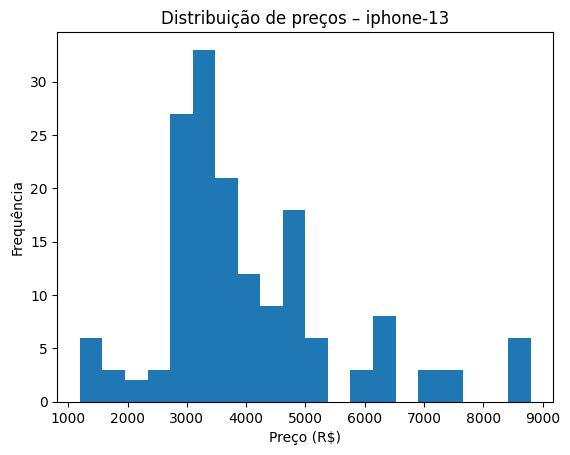

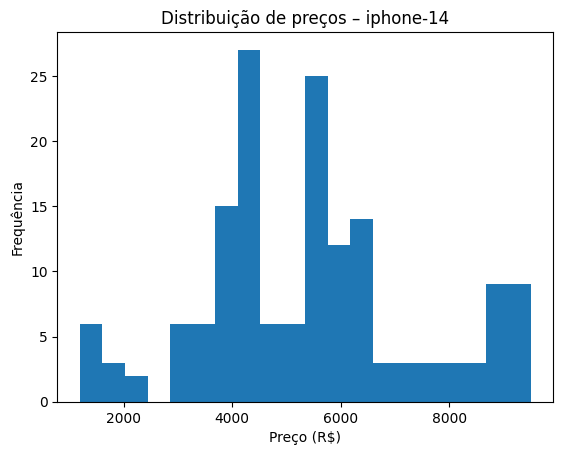

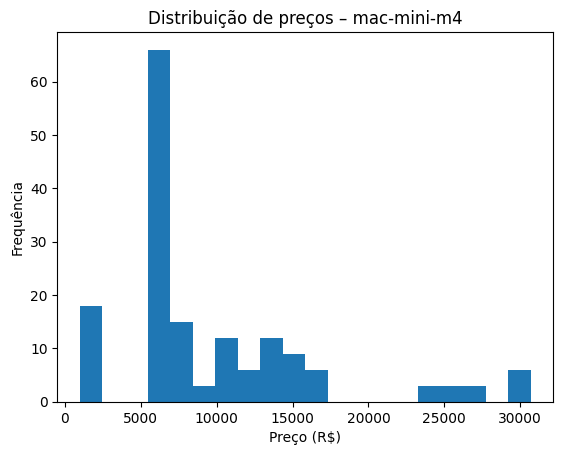

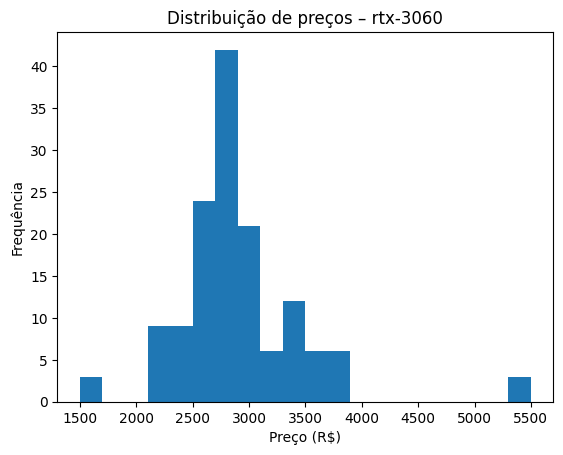

In [110]:
for k, d in data.items():
    d["price"].dropna().plot.hist(
        bins=20,
        title=f"Distribuição de preços – {k}",
        xlabel="Preço (R$)",
        ylabel="Frequência",
    )
    plt.show()


### 6.5 Distribuição de vendas  
Histogramas por *keyword* (um gráfico por produto).


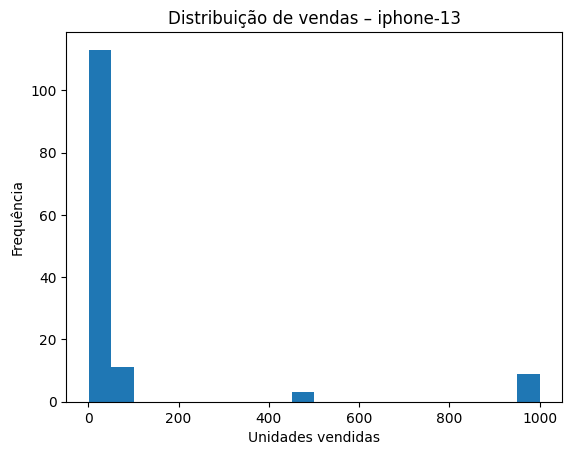

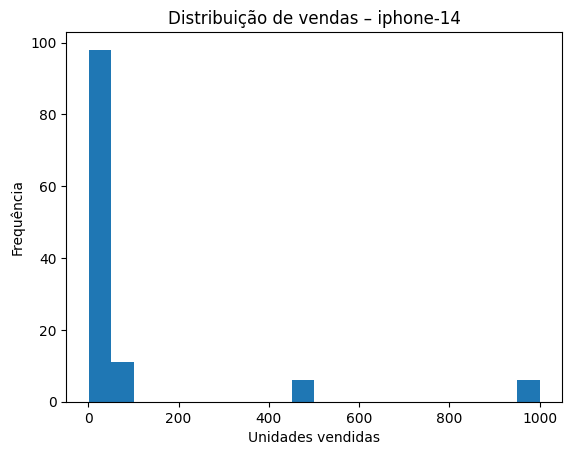

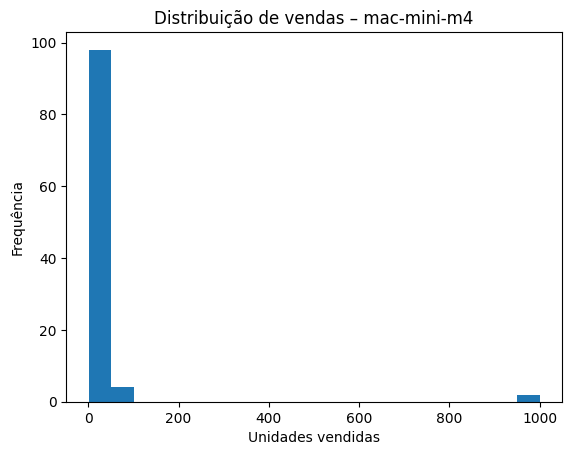

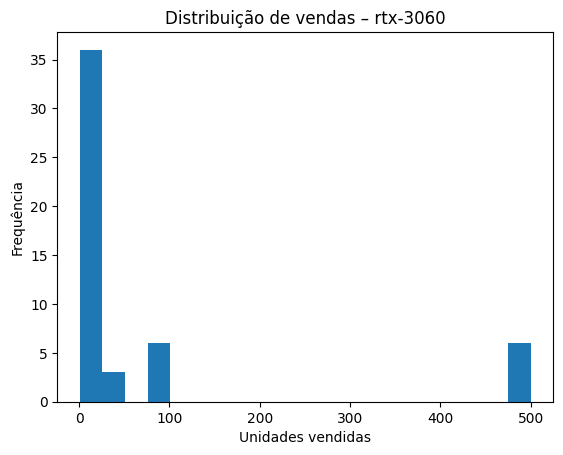

In [111]:
for k, d in data.items():
    d["sold_qty"].dropna().plot.hist(
        bins=20,
        title=f"Distribuição de vendas – {k}",
        xlabel="Unidades vendidas",
        ylabel="Frequência",
    )
    plt.show()
